In [57]:
import pandas as pd
import optuna
import optunahub
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from optuna.samplers import TPESampler

In [60]:
db_path = "sqlite:///../Data/optuna.db"
study_name = "iml_experiment_v7"

# Create a new study or load an existing one
study = optuna.create_study(study_name=study_name,
                            storage=db_path,
                            load_if_exists=True,
                            direction="minimize",
                            sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler()
                            )

# Load the data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Split the data
X = train.drop(columns=["log_pSat_Pa", "ID", "parentspecies"])
y = train["log_pSat_Pa"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=75)

[I 2024-11-22 02:10:56,698] Using an existing study with name 'iml_experiment_v7' instead of creating a new one.


In [61]:
def improved_objective_func(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 1300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.25, 0.75),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 15, 150),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        "max_depth": trial.suggest_int('max_depth', 3, 15),
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0, 15),
        "lambda_l1": trial.suggest_int('lambda_l1', 1, 100, step=5),
        "lambda_l2": trial.suggest_int('lambda_l2', 1, 100, step=5),
        'random_state': 75
    }
    model = lgb.LGBMRegressor(**params, verbose=-1)
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    mae = mean_absolute_error(test_y, preds)
    return mae

study.optimize(improved_objective_func, n_trials=100)

/home/saavajuu/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning:

The distribution is specified by [1, 100] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 96].

[I 2024-11-22 02:10:59,464] Trial 0 finished with value: 1.2293339926735267 and parameters: {'n_estimators': 404, 'learning_rate': 0.0986070962606092, 'subsample': 0.5094113667196974, 'subsample_freq': 2, 'feature_fraction': 0.2, 'min_child_samples': 40, 'num_leaves': 37, 'max_depth': 14, 'min_gain_to_split': 8.873375988029157, 'lambda_l1': 71, 'lambda_l2': 1}. Best is trial 0 with value: 1.2293339926735267.
/home/saavajuu/.cache/optunahub/api.github.com/optuna/optunahub-registry/main/package/samplers/auto_sampler/_sampler.py:164: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

/home/saavajuu/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning:

The distribution is specif

In [62]:
print("Best MAE", study.best_value)
print("Best params:", study.best_trial.params)

# train the model with the best params
best_params = study.best_trial.params
model = lgb.LGBMRegressor(**best_params, verbose=-1)
model.fit(train_x, train_y)
preds = model.predict(test_x)
mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, preds)
print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)

Best MAE 1.1476257955769629
Best params: {'n_estimators': 1300, 'learning_rate': 0.017510332606495215, 'subsample': 0.75, 'subsample_freq': 1, 'feature_fraction': 0.9, 'min_child_samples': 15, 'num_leaves': 50, 'max_depth': 8, 'min_gain_to_split': 0.0, 'lambda_l1': 1, 'lambda_l2': 96}
MAE: 1.1476292690592522
MSE: 2.4749279576679317
R2: 0.7424765323557665


In [64]:
important_hyperparams = sorted(study.best_trial.params, key=study.best_trial.params.get, reverse=True)[:3]
optuna.visualization.plot_slice(study=optuna.load_study(study_name=study_name, storage=db_path), params=important_hyperparams)

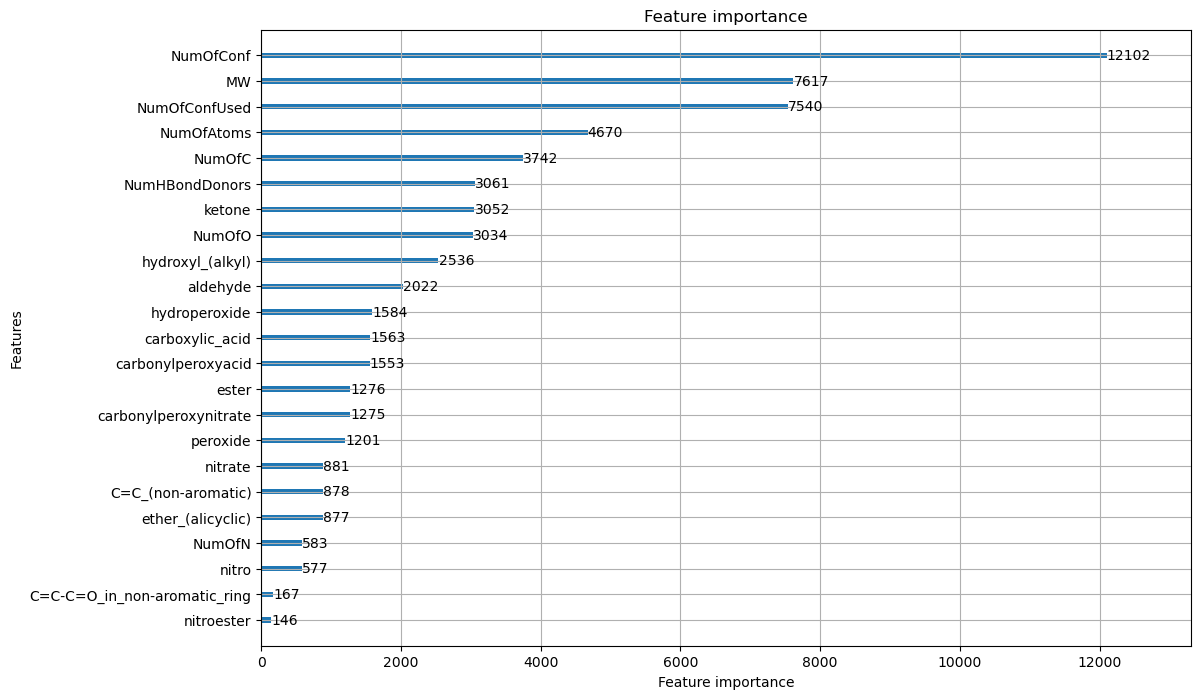

In [65]:
# Plot the feature importance
fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, ax=ax)
plt.show()

# plot hyperparameter importance
optuna.visualization.plot_param_importances(study).show()


In [66]:
# do the predictions to the test data and store the results in column : TARGET

if "TARGET" in test.columns:
    test = test.drop(columns=["TARGET"])
test["TARGET"] = model.predict(test.drop(columns=["ID", "parentspecies"]))

# save the ID and TArGET columns to a csv file called : optana_lgbm.csv
test[["ID", "TARGET"]].to_csv("optana_lgbm.csv", index=False)